# TEXTANALYTICS IN SAS VIYA: TOPIC MODELLING AND SENTIMENT ANALYSIS

In [2]:
option casport=5570 cashost="localhost";
cas casauto;
caslib _all_ assign;



In [3]:
libname viyalab CAS SESSREF=casauto  caslib=CASUSER;
DATA viyalab.engstop;                           
	set sashelp.engstop;
RUN;

In [5]:
%LET path=/opt/open/manualrg/;

PROC IMPORT  DATAFILE="&path.movie_rev.txt"
		OUT=viyalab.CORPUS
		DBMS=DLM replace; 
	DELIMITER="|"; 
RUN;



In [6]:
PROC CONTENTS DATA=viyalab.corpus;  
RUN;

PROC PRINT DATA=viyalab.corpus(obs=10);  
RUN;

PROC PRINT DATA=sashelp.engstop (obs=10);  
RUN;

## Topic Modelling

In [7]:
PROC CAS;
   loadactionset "textMining";                  
   action tmMine;
   param
   docId="id"
   documents={ name="corpus"}
   text="text"
   nounGroups=False
   language="ENGLISH" /*default ENGLISH*/
   stemming=TRUE /*default TRUE*/
   tagging = True /*TRUE*/
   stopList ={ name="engstop"}
   /*entities="STD"*/
   parseConfig={name="config", replace=TRUE}
   parent ={ name="parent",replace=TRUE}
   offset ={name="offset",replace=TRUE}
   terms ={ name="terms", replace=TRUE}
   reduce=1
   k=3
   /*output*/
   docPro ={ name="docpro", replace=TRUE}
   topics ={ name="topics", replace=TRUE}
   u ={ name="svdu", replace=TRUE}
   numLabels=3 /*specifies the number of terms to use in the descriptive label for each topic.*/
   topicDecision=True;
   
	action table.fetch /table="topics", orderBy="_TopicID_"; run;
	action table.fetch /table="docpro", orderBy="id"; run;
	action table.fetch /table="svdu", orderBy="_TermNum_"; run;
	run;
QUIT;

Term Distribution Analysis

In [8]:

/*Term analysis*/
PROC PRINT DATA=viyalab.terms (OBS=100);
RUN;
PROC SORT DATA=viyalab.terms OUT=terms_srt;
	by descending _Frequency_;
RUN;
DATA terms_ranking top_10_terms;
	set terms_srt;
	rank=_N_;
	if rank<=10 then output top_10_terms;
	output terms_ranking;
RUN;

Obs,_Term_,_Role_,_Attribute_,_Frequency_,_NumDocs_,_Keep_,_Termnum_,_Parent_,_ParentId_,_IsPar_,_Weight_
1,et al.,Adv,Abbr,1,1,Y,1,.,1,,1
2,josie,Noun,Alpha,1,1,Y,2,.,2,,1
3,academy,Noun,Alpha,2,2,Y,3,.,3,,0.9218185368
4,cars,Noun,Alpha,1,1,Y,1819,1004,1004,.,1
5,heart,Noun,Alpha,2,2,Y,4,.,4,,0.9218185368
6,luck,Verb,Alpha,1,1,Y,5,.,5,,1
7,pirated,Verb,Alpha,1,1,Y,1820,1555,1555,.,1
8,othe,Noun,Alpha,1,1,Y,6,.,6,,1
9,gayness,Prop,Alpha,1,1,Y,7,.,7,,1
10,viewings,Noun,Alpha,1,1,Y,1821,1006,1006,.,1



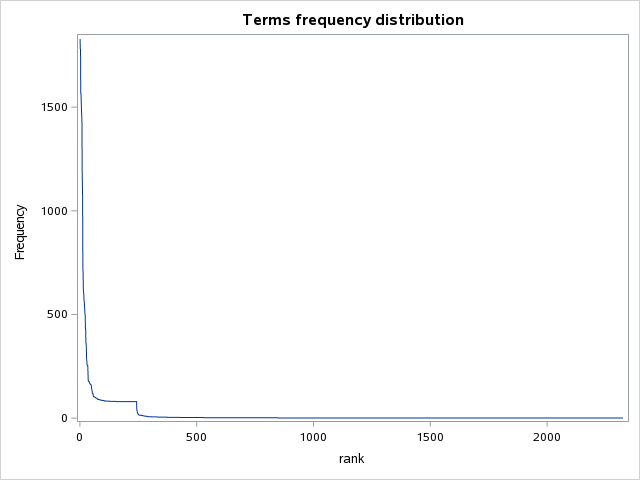

In [9]:
PROC SGPLOT DATA= terms_ranking;
	title "Terms frequency distribution";
	series x=rank y= _Frequency_;
RUN;
title;


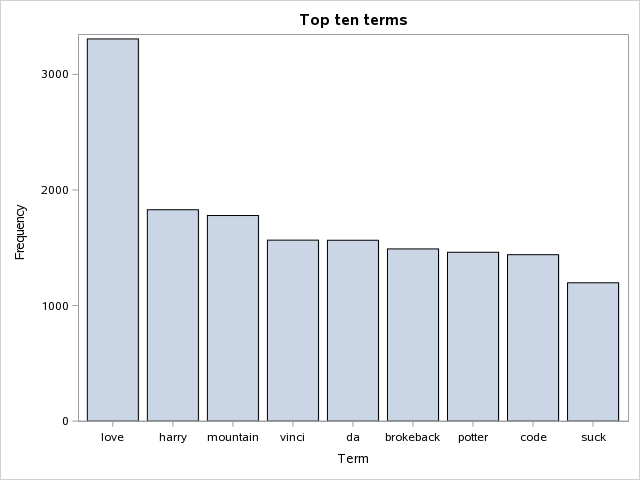

In [10]:
PROC SGPLOT DATA= top_10_terms;
	title "Top ten terms";
	vbar _Term_ / response=_Frequency_ categoryorder=respdesc;
RUN;
title;


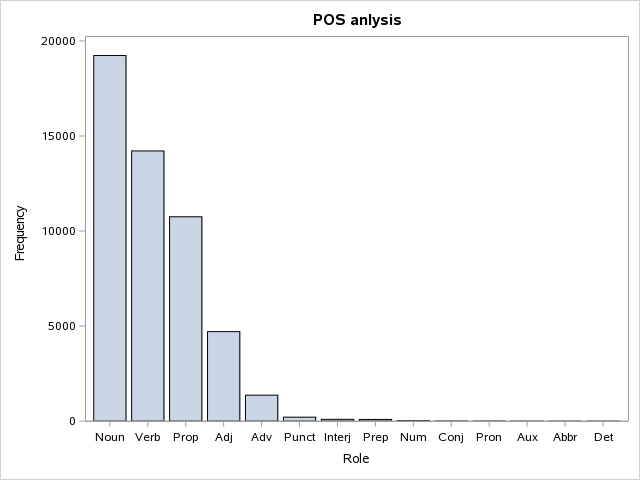

In [11]:

/*POS Analysis: Entity extraction candidates*/
PROC SGPLOT DATA= terms_ranking;
	title "POS anlysis";
	vbar _Role_ / FREQ=_Frequency_ categoryorder=respdesc;
RUN;

In [12]:
PROC SQL OUTOBS=25;
	SELECT _Term_, rank,  _Frequency_, _NumDocs_
	FROM terms_ranking
	WHERE _Role_="Noun"
	order by _Frequency_ desc;
QUIT;


Term,rank,Frequency,Number of Documents
mountain,3,1779,1779
potter,8,1461,1458
movie,12,1059,1050
mission,13,729,729
movie,14,698,692
code,20,542,540
brokeback,22,504,504
vinci,25,433,431
movies,27,361,361
suck,29,281,281


Topic Analysis


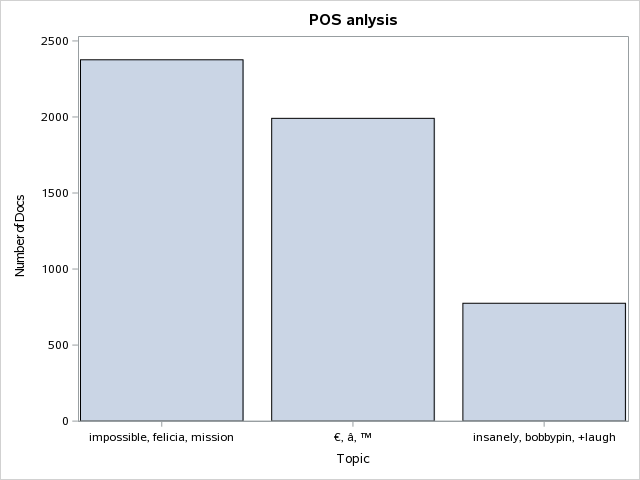

In [13]:
PROC SGPLOT DATA=viyalab.topics;
	vbar _Name_ / response= _Numdocs_ categoryorder=respdesc;
RUN;


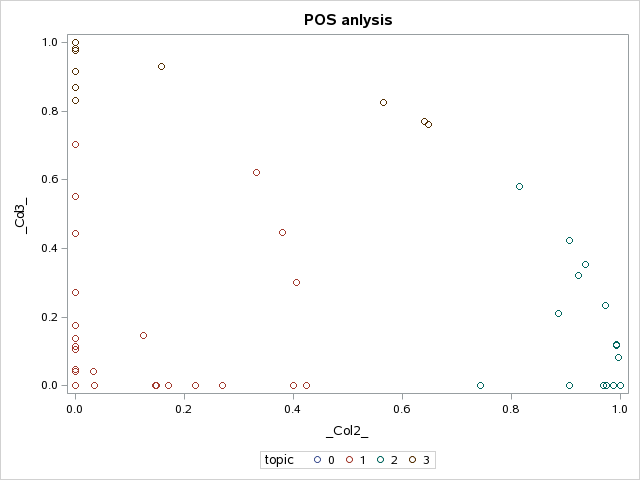

In [14]:
DATA viyalab.docpro_topics;
	set viyalab.docpro;
	if (_col1_>_col2_) and (_col1_>_col3_) then topic=1;
	else if _col2_>_col1_ and _col2_>_col3_ then topic=2;
	else if _col3_>_col1_ and _col3_>_col1_ then topic=3;
	else topic=0;
RUN;
	
PROC SGPLOT DATA=viyalab.docpro_topics;
	scatter x=_col2_ y=_col3_ / group=topic;
RUN;

In [15]:

PROC FEDSQL SESSREF=casauto;
	CREATE TABLE docpro_topics_labelled AS
		select mas.id, mas.label, det.topic
		from corpus as mas
		inner join docpro_topics as det
			on mas.id=det.id;
QUIT;

PROC FEDSQL SESSREF=casauto;
		select topic, 
			sum(label)/count(*) as eprop
		from docpro_topics_labelled 
		group by  topic
		order by topic;
QUIT;

topic,EPROP
0,0.463134
1.000000,0.496507
2.000000,0.289063
3.000000,0.722112


## Sentiment Analysis

In [16]:
PROC CAS;
 	session casauto;
	loadactionset "sentimentAnalysis";                         /* 2 */

	action sentimentAnalysis.applySent;                        /* 3 */
		param
			docId="id"
			text="text"
			threshold=0.5 /*specifies the positive probability threshold value. The default value is 0.5.*/
			table={name="corpus"}
			casOut={name="corpus_sent", replace=TRUE}
		;
run; 
QUIT;	

PROC PRINT DATA=viyalab.corpus_sent (OBS=10);
RUN;

Sentiment Analysis Assessment

In [17]:

PROC FEDSQL SESSREF=casauto;
	CREATE TABLE corpus_sent_labelled AS
		select mas.id, mas.label, det._sentiment_, det._probability_
		from corpus as mas
		inner join corpus_sent as det
			on mas.id=det.id;
QUIT;

PROC FEDSQL SESSREF=casauto;
	CREATE TABLE confussion_mat AS
		select label, _sentiment_, 
			count(*) as N,
			min(_probability_) as min_prob,
			mean(_probability_) as Mean_prob,
			max(_probability_) as max_prob
	
		from corpus_sent_labelled 
		group by  label, _sentiment_;
QUIT;

PROC PRINT DATA=viyalab.confussion_mat;
RUN;

Obs,label,_sentiment_,N,MIN_PROB,MEAN_PROB,MAX_PROB
1,0,Negative,2110,0.16495,0.38838,0.40000
2,0,Neutral,880,0.50000,0.50000,0.50000
3,0,Positive,101,0.60000,0.60183,0.69231
4,1,Negative,106,0.22857,0.39751,0.40000
5,1,Neutral,633,0.50000,0.50000,0.50000
6,1,Positive,3256,0.60000,0.61383,0.83505


## DOCUMENT CLASSIFICATION BY BUILDING BOOLEAN RULES

In [15]:

PROC CAS;
  loadactionset "textMining";
  tmMine / documents='corpus' text='text' docid='id'
           parent={name='parent', replace=1} terms={name='terms', replace=1}
           parseConfig={name='config', replace=1} offset={name='pos', replace=1}
           entities='None' NounGroups=0 stemming=1 tagging=0 reduce=1;
RUN;

PROC PRINT DATA=viyalab.parent (OBS=10);
RUN;

PROC PRINT DATA=viyalab.terms (OBS=10);
RUN;

In [16]:
PROC CAS;
  loadactionset "boolRule";
  brTrain / table='parent' docid='_document_' termid='_termnum_' minsupports=1
            mPositive=1 gPositive=1
            docinfo={table='corpus', id='id', targettype='BINARY',
               targets={'label'}}
            terminfo={table='terms', id='_termnum_', label='_term_'}
            casOuts={rules={name='review_rules' replace=1},
               ruleterms={name='review_ruleterms' replace=1}};
RUN;


PROC CAS;
  fetch / table='review_rules';
RUN;

PROC CAS;
  fetch / table='review_ruleterms';
RUN;